In [1]:
import symlens as s
from pixell import enmap, utils as putils, powspec
import os,sys
from scipy.interpolate import interp1d
import numpy as np
from orphics import maps, cosmology
import healpy as hp
from pixell import utils, enmap, curvedsky, enplot, wcsutils, powspec, lensing
import os
import numpy as np

import matplotlib.pyplot as plt
import lmdb
from cosmikyu import datasets, transforms, gan, model, stats, sehgal
from cosmikyu import nn as cnn
from cosmikyu import utils as cutils
from cosmikyu import config as cconfig
import torch
from orphics import maps as omaps
from pitas import power, flipper_tools, config
import scipy
from minkfncts2d import MF2D

import scipy.stats 
import math

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
camb_file = "/home/dwhan89/scratch/data/sehgal_et_al_sims/theoryCls/bode_almost_wmap5_lmax_1e4_lensedCls.dat"
lmax = 10000

input_dir = "/home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/131020_hybrid_projection"
shape, wcs = enmap.fullsky_geometry(res=0.5*utils.arcmin)
ydel = shape[0] // 9
xdel = shape[1] // 9
print(shape, ydel)
template = enmap.zeros(shape, wcs)[ydel*4:(ydel)*5,:]
nshape, nwcs = template.geometry

w = np.sum(enmap.zeros(nshape,nwcs).pixsizemap())/(4*np.pi)

plot_dir = "/home/dwhan89/scratch/outbox/cosmikyu"
def plot_path(x):
    return os.path.join(plot_dir, x)

S10R = sehgal.Sehgal10Reprojected(input_dir, nshape, nwcs)
compts = ["kappa", "ksz", "tsz", "ir", "rad"]

(21601, 43200) 2400


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
cuda = True
show_plot=True 
ngpu = 4
norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/201020_logzshrink_normalization_info_validation.npz"
spec_file = "/home/dwhan89/scratch/data/sehgal_et_al_sims/theoryCls/clkk_sim.npy"
cmb_spec_file = "/home/dwhan89/scratch/data/sehgal_et_al_sims/theoryCls/bode_almost_wmap5_lmax_1e4_scalCls.dat"

experiment_id = "1d2d87ba56dc4b229b4dae000c0e878b"
save_point = 4
model_dir = "/home/dwhan89/workspace/cosmikyu/output/sehgal_pixganwgp_301020/{}/model".format(experiment_id)
pixgan_state_file = os.path.join(model_dir, "generator{}.pt".format("_{}".format(save_point)))

experiment_id = "ec72a32f599f4ccda54a556ba56abea4"
save_point = 3
model_dir = "/home/dwhan89/workspace/cosmikyu/output/sehgal_forse_081020/{}/model".format(experiment_id)
tuner_state_file = os.path.join(model_dir, "generator{}.pt".format("_{}".format(save_point)))

transfer_file = os.path.join(input_dir,"221120_sehgal_network_transfer.npy")
radio_profile_file = os.path.join(input_dir, "091220_radio_profilev5.npy")
cib_profile_file = os.path.join(input_dir, "091220_cib_profilev1.npy")
#radio_profile_file = cib_profile_file

output_dir = cconfig.default_output_dir
cache_dir = os.path.join(output_dir, "cache")
sim_dir = os.path.join(output_dir, "sim")

os.makedirs(sim_dir, exist_ok=True)
os.makedirs(cache_dir, exist_ok=True)


SN = sehgal.SehgalNetwork(nshape, nwcs, cuda, ngpu, 256, norm_info_file, pixgan_state_file,
                          tuner_state_file, spec_file, transfer_file, radio_profile_file,cib_profile_file, 20, cache_dir=cache_dir
                          )


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Loading /home/dwhan89/workspace/cosmikyu/output/sehgal_pixganwgp_301020/1d2d87ba56dc4b229b4dae000c0e878b/model/generator_4.pt
Loading /home/dwhan89/workspace/cosmikyu/output/sehgal_forse_081020/ec72a32f599f4ccda54a556ba56abea4/model/generator_3.pt


In [4]:
overwrite= False
if overwrite:


    cls_s10 = np.zeros((lmax+1,6))
    cls_s10[:,0] = np.arange(lmax+1)
    ctr = 0
    for theta in [0, 20, 40, 60, 80]:
        _, alm_s10 = S10R.get_maps(0, theta, use_sht=True, ret_alm=True, flux_cut=7)
        cls_s10[:,1] += hp.alm2cl(alm_s10[0])
        cls_s10[:,2] += hp.alm2cl(alm_s10[1])
        cls_s10[:,3] += hp.alm2cl(alm_s10[2])
        cls_s10[:,4] += hp.alm2cl(alm_s10[3])
        cls_s10[:,5] += hp.alm2cl(alm_s10[4])
        ctr += 1
    print(ctr)
    cls_s10[:,1:] /= ctr

    np.save("/home/dwhan89/scratch/data/sehgal_et_al_sims/theoryCls/cls_s10.npy", cls_s10)
else:
    cls_s10 = np.load("/home/dwhan89/scratch/data/sehgal_et_al_sims/theoryCls/cls_s10.npy")
    
sigma=10
overwrite = True
s12_pced_file = "/home/dwhan89/scratch/data/sehgal_et_al_sims/theoryCls/cls_s10_gauss_12sigma_7mjy.npy"
if overwrite:
    cls_s10_pced = np.zeros((lmax+1,6))
    cls_s10_pced[:,0] = np.arange(lmax+1)
    cls_s10_pced[2:,1] = scipy.ndimage.gaussian_filter1d(cls_s10[2:,1], sigma=sigma)
    cls_s10_pced[2:,2] = scipy.ndimage.gaussian_filter1d(cls_s10[2:,2], sigma=sigma)
    cls_s10_pced[2:,3] = scipy.ndimage.gaussian_filter1d(cls_s10[2:,3], sigma=sigma)
    cls_s10_pced[2:,4] = scipy.ndimage.gaussian_filter1d(cls_s10[2:,4], sigma=sigma)
    cls_s10_pced[2:,5] = scipy.ndimage.gaussian_filter1d(cls_s10[2:,5], sigma=sigma)
    cls_s10_pced[:2,:] = cls_s10[:2,:].copy()
    np.save(s12_pced_file, cls_s10_pced)
else:
    cls_s10_pced = np.load(s12_pced_file)

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
overwrite=True
ng_raw_file = "/home/dwhan89/scratch/data/sehgal_et_al_sims/theoryCls/cls_ngv3.npy"
if overwrite:
    cls_ng = cls_s10_pced.copy()
    cls_ng[:,1:] = 0.
    ctr = 0
    for sim_idx in range(1000,1010):
        ngfgmaps = SN.generate_samples(
            seed=sim_idx,
            ret_corr=False,
            wrap=True,
            wrap_mode=('reflect', 'wrap'),
            edge_blend=True,
            verbose=True,
            input_kappa=None,
            transfer=False,
            deconv_beam=True,
            use_sht=False,
            post_processes=[],
            use_cache=False,
            flux_cut=7,
            niter_fista=100
        )
        alm_ng = {}
        for i in range(5):
            alm_ng[i] = curvedsky.map2alm(enmap.enmap(ngfgmaps[i], wcs=nwcs), lmax=lmax)

        cls_ng[:,1] += hp.alm2cl(alm_ng[0])
        cls_ng[:,2] += hp.alm2cl(alm_ng[1])
        cls_ng[:,3] += hp.alm2cl(alm_ng[2])
        cls_ng[:,4] += hp.alm2cl(alm_ng[3])
        cls_ng[:,5] += hp.alm2cl(alm_ng[4])

        ctr += 1
    print(ctr)
    cls_ng[:,1:] /= ctr
    np.save(ng_raw_file, cls_ng)
else:
    cls_ng = np.load(ng_raw_file)
    
overwrite=True
ng_pced_file = "/home/dwhan89/scratch/data/sehgal_et_al_sims/theoryCls/cls_s10_ngv3_xxsigma.npy"
if overwrite:
    sigma = 7
    cls_ng_pced = np.zeros((lmax+1,6))
    cls_ng_pced[:,0] = np.arange(lmax+1)
    cls_ng_pced[2:,1] = scipy.ndimage.gaussian_filter1d(cls_ng[2:,1], sigma=sigma)
    cls_ng_pced[2:,2] = scipy.ndimage.gaussian_filter1d(cls_ng[2:,2], sigma=sigma)
    cls_ng_pced[2:,3] = scipy.ndimage.gaussian_filter1d(cls_ng[2:,3], sigma=sigma)
    cls_ng_pced[2:,4] = scipy.ndimage.gaussian_filter1d(cls_ng[2:,4], sigma=sigma)
    cls_ng_pced[2:,5] = scipy.ndimage.gaussian_filter1d(cls_ng[2:,5], sigma=sigma)
    cls_ng_pced[:2,:] = cls_ng[:2,:].copy()
    np.save(ng_pced_file, cls_ng_pced)
else:
    cls_ng_pced = np.load(ng_pced_file)
    

making input gaussian kappa
make the primary images
batch 0/26 completed
batch 20/26 completed
make the blending images
starting vertical blending
batch 0/24 completed
batch 20/24 completed
starting horizontal blending
batch 0/26 completed
batch 20/26 completed
deconvolving beam
point source iteratively beam deconv
FISTA optimization (soft thresholding)
-----------------------------------------------------------
The Operator Op has 103680000 rows and 103680000 cols
eps = 1.000000e-01	tol = 1.000000e-10	niter = 100
alpha = 9.999901e-01	thresh = 4.999951e-02
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1   4.97846e-02   1.991e+05   1.383e+06   1.258e+03
     2   6.36161e-02   1.718e+05   1.356e+06   1.829e+02
     3   6.53521e-02   1.566e+05   1.342e+06   1.496e+02
     4   5.68921e-02   1.472e+05   1.336e+06   1.228e+02
     5   4.03312e-02   1.415e+05   1.332e+06   1.032e+02
     6   1.74771e-02   1.379e+05   

In [6]:
_, alm_s10 = S10R.get_maps(60, 40, use_sht=True, ret_alm=True, compts=["ir_pts"], flux_cut=7, load_processed=False)

loading /home/dwhan89/scratch/data/sehgal_et_al_sims/cosmo_sim_maps/July2009/output/131020_hybrid_projection/148_ir_pts_alm_060_040_000.fits


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


adding high flux cats


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


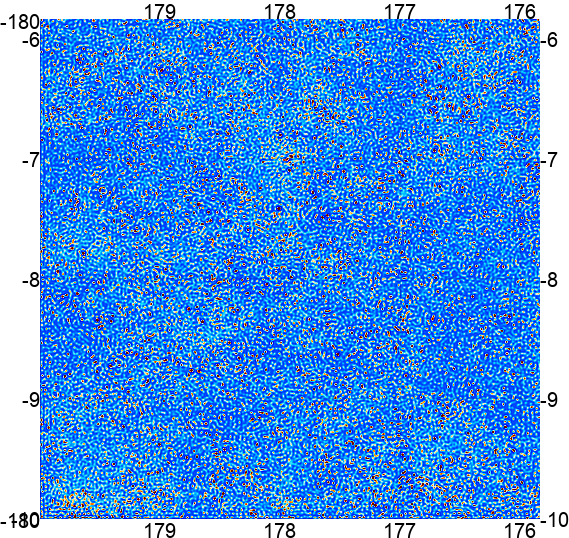

-71.02944609499677 709.1342379521293


In [11]:
enplot.pshow(ngfgmaps[3][:500,:500])
print(np.min(ngfgmaps[3]),np.max(ngfgmaps[3]))
#enplot.pshow(ngfgramaps[4][:500,:500])

In [ ]:
old_transfer = np.load(os.path.join(input_dir,"071220_sehgal_network_transferv4.npy"))

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


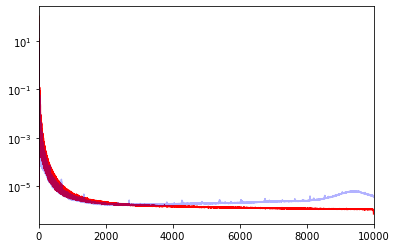

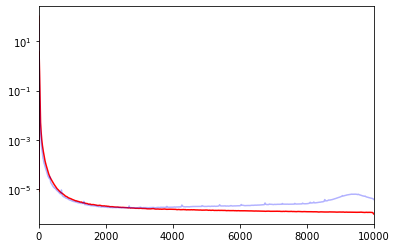

In [13]:
idx = 4
plt.plot(cls_s10_pced[:,0], cls_s10[:,idx], color="r")
plt.plot(cls_ng_pced[:,0], cls_ng[:,idx],alpha=0.3, color="b")
#plt.plot(cls_ng_pced[:,0], cls_ng_pced[:,idx]/w**2,alpha=0.3)
plt.yscale("log")
plt.xlim(0,10000)
plt.show()

plt.plot(cls_s10_pced[:,0], cls_s10_pced[:,idx], color="r")
plt.plot(cls_ng_pced[:,0], cls_ng_pced[:,idx],alpha=0.3, color="b")
plt.yscale("log")
plt.xlim(0,10000)
plt.show()

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


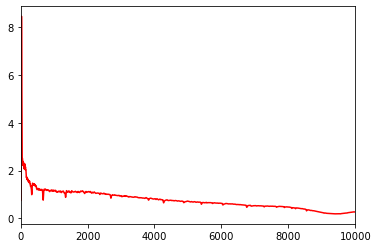

In [15]:
idx = 4
plt.plot(cls_s10_pced[:,0], (cls_s10_pced[:,idx]/(cls_ng_pced[:,idx])), color="r")
#plt.plot( old_transfer[:lmax,0], old_transfer[:lmax,idx]**2, color="b")
plt.yscale("linear")
plt.xlim(0, 10000)
#plt.ylim(0,4000)
plt.show()

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


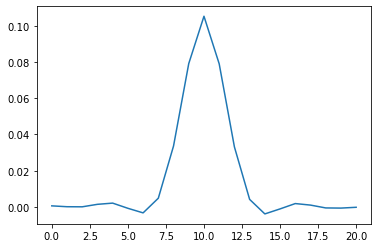

In [24]:
#plt.imshow(SN.pt_src_profiles[3])
plt.plot(SN.pt_src_profiles[3][:,10])

In [ ]:
new_transfer = cls_ng_pced.copy()
new_transfer[2:,1] = np.sqrt(cls_s10_pced[2:,1]/(cls_ng_pced[2:,1]))
new_transfer[2:,2] = np.sqrt(cls_s10_pced[2:,2]/(cls_ng_pced[2:,2]))
new_transfer[2:,3] = np.sqrt(cls_s10_pced[2:,3]/(cls_ng_pced[2:,3]))
new_transfer[2:,4] = np.sqrt(cls_s10_pced[2:,4]/(cls_ng_pced[2:,4]))
new_transfer[2:,5] = np.sqrt(cls_s10_pced[2:,5]/(cls_ng_pced[2:,5]))
new_transfer[1,1:] = 0
new_transfer[0,1:] = np.sqrt(cls_s10[0,1:]/(cls_ng[0,1:]))

idx = 3
plt.plot(new_transfer[:,0], new_transfer[:,idx]**2, color="r")
#plt.plot( old_transfer[:lmax,0], old_transfer[:lmax,idx]**2, color="b")
plt.yscale("linear")
plt.xlim(0,10000)
#plt.ylim(0,2)
plt.show()

new_transfer_file = os.path.join(input_dir,"071220_sehgal_network_transferv9.npy")
np.save(new_transfer_file, new_transfer)

In [ ]:
plt.plot((cls_s10_pced[2:,1]/(cls_ng_pced[2:,1]/w**2)*x)*(cls_ng[2:,1]/w**2))
plt.plot(cls_s10[2:,1])